[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaik-rehna/Multi-Class-Image-Classification-on-Medical-Dataset/blob/main/HAM10000_Project_Focal_loss.ipynb)


### **MULTI CLASS IMAGE CLASSIFICATION ON MEDICAL DATASET**

##### This project aims to develop a benchmark for long-tailed, multi-class medical image classification, using the HAM10000 Dataset that was acquired with a variety of dermatoscope types that are categorized into one of seven possible disease categories

In [ ]:
# General
import os, pickle                # For file operations, data persistence
from pathlib import Path         # Path handling
from tqdm import tqdm            # Progress bars for loops (great for monitoring processes like data preprocessing or model training)

# Data manipulation
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical operations
import random

# Visualizations
import matplotlib.pyplot as plt       # For plotting data distributions, creating bar charts, and visualizing class imbalance
import matplotlib.patches as patches  # Annotating images (bounding boxes around lesions)
import seaborn as sns                 # For creating statistical plots

# Image manipulation
import PIL, cv2
# PIL (Pillow): Simple image manipulation like resizing, cropping, and saving
# OpenCV: Advanced image processing (augmentation, histogram equalization, denoising)

from math import ceil      # For handling fractional computations (dividing datasets into folds)

from skimage.io import imread, imshow    # Reading and displaying images from NumPy arrays

import torch

from sklearn import metrics, model_selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/HAM10000_DATASET')

# Confirm the current working directory
print(os.getcwd())

/content/drive/MyDrive/HAM10000_DATASET


In [ ]:
data_path = Path("/content/drive/MyDrive/HAM10000_DATASET")
os.listdir(data_path)

['HAM10000_metadata.csv',
 'GroundTruth.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2']

In [ ]:
data_path = Path("/content/drive/MyDrive/HAM10000_DATASET")
csv_path = data_path / 'HAM10000_metadata.csv'
df_data = pd.read_csv(csv_path)
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df_data = pd.read_csv(csv_path).set_index('image_id')
# Sets the image_id column as the index, which will help in matching images with their corresponding labels.
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [ ]:
print(f"No.of rows:{df_data.shape[0]}")
print(f"No.of columns:{df_data.shape[1]}")

No.of rows:10015
No.of columns:6


In [ ]:
# Categories of the diferent diseases (kaggle.com/ingbiodanielh/skin-cancer-classification-with-resnet-50-fastai)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx = df_data.dx.astype('category',copy=True)  # Converts the dx column (disease codes) to a categorical data

In [ ]:
print(df_data.dx.cat.categories)

Index(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype='object')


In [ ]:
print(df_data.dx.cat.codes)

image_id
ISIC_0027419    2
ISIC_0025030    2
ISIC_0026769    2
ISIC_0025661    2
ISIC_0031633    2
               ..
ISIC_0033084    0
ISIC_0033550    0
ISIC_0033536    0
ISIC_0032854    0
ISIC_0032258    4
Length: 10015, dtype: int8


In [ ]:
df_data['label'] = df_data.dx.cat.codes # Convert the labels to numbers

In [ ]:
df_data['lesion_type'] = df_data.dx.map(lesion_type_dict)
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [ ]:
# create key relating label to lesion_type
label_list = df_data['label'].value_counts().keys().tolist()
lesion_list = df_data['lesion_type'].value_counts().keys().tolist()
label_to_lesion = dict(zip(label_list, lesion_list))
label_to_lesion_sorted = dict(sorted(label_to_lesion.items()))
label_to_lesion_sorted

{0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis ',
 3: 'Dermatofibroma',
 4: 'Melanoma',
 5: 'Melanocytic nevi',
 6: 'Vascular lesions'}

In [ ]:
# The images are spread over two folders, HAM10000_images_part_1 and HAM_10000_images_part_2
# add a column to the df with the path to the correct folders

# Create a dictionary mapping filenames to full image paths
# This time, we'll preserve the full desired path

data_path = Path("/content/drive/MyDrive/HAM10000_DATASET")

imageid_path_dict = {
    str(x).split('/')[-1][:-4]: os.path.join(
        '/content/drive/MyDrive/HAM10000_DATASET',
        x.parent.name,  # This captures 'HAM10000_images_part_1' or 'HAM10000_images_part_2'
        f'{str(x).split("/")[-1]}'
    )
    for x in list(data_path.glob('*/*.jpg'))
}

# Add paths to the DataFrame
df_data['path'] = [
    Path(imageid_path_dict[fn]) for fn in df_data.index.values
]

In [ ]:
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
image_id,,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...


In [ ]:
df_data.reset_index().to_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_metadata.csv', index=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Checking the size of the images
img_sizes = set()
for row in df_data.itertuples():
    img = load_img(row.path)
    img_sizes.add(img.shape)

print(f'Image sizes: {img_sizes}')

Image sizes: {(450, 600)}


##### All the images have the same size i.e., 450x600

In [ ]:
def show_examples(df, col, n_samples=5):
    """
    Show `n_samples` of each type of value in `col` of dataframe `df`
    Args:
        df (DataFrame): DataFrame containing image paths and labels
        col (str): Column name in `df` to group by
        n_samples (int): Number of samples per group to display
    """
    # Group data by the specified column
    groups = df.sort_values([col]).groupby(col, observed=False)   # "groups" is a list containing various unique values in the col
    n_rows = len(groups)

    # Create subplots
    fig, m_axs = plt.subplots(n_rows, n_samples, figsize=(10,10))

    # If there's only one row, m_axs isn't a list; wrap it in a list
    if n_rows == 1:
        m_axs = [m_axs]

    # Loop through groups and plot images
    for n_axs, (type_name, type_rows) in zip(m_axs, groups):
        n_axs[0].set_title(type_name)  # Set the group name as title
        sample_rows = type_rows.sample(min(len(type_rows), n_samples))  # Handle cases with < n_samples

        for c_ax, (_, c_row) in zip(n_axs, sample_rows.iterrows()):
            try:
                # Read and display image
                img = imread(c_row['path'])
                c_ax.imshow(img)
                c_ax.axis('off')  # Turn off axes
            except FileNotFoundError:
                c_ax.axis('off')  # In case the image path is invalid
                c_ax.set_title("Image Not Found")

    plt.tight_layout()
    plt.show()

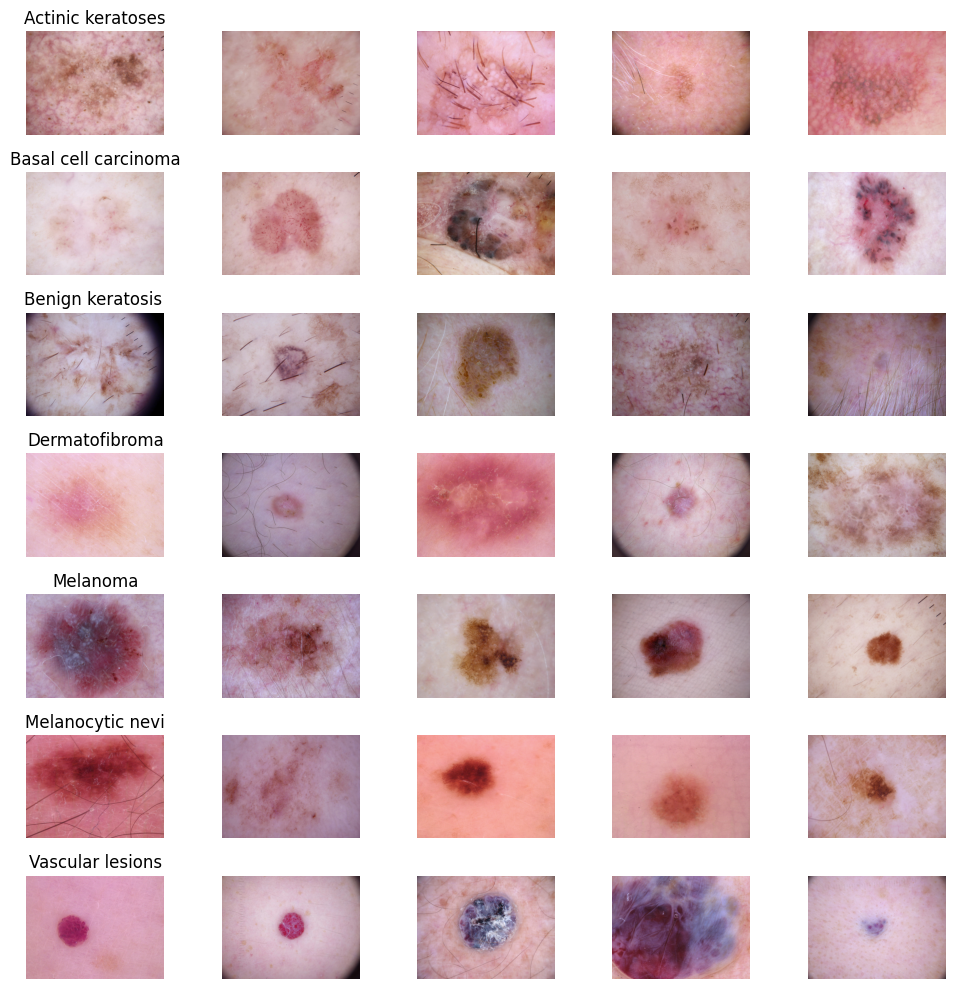

In [ ]:
# some examples of each lesion
show_examples(df_data, 'lesion_type', 5)

#### **Analyzing the data using plots**

##### Since, the bar plot representation will be used frequently , writing a definition for it will make the task easy. We need not write the common barplot specifications again and again for diff plots

In [ ]:
def bar_plt(x, y, title):
    sns.barplot( x=x, y=y, hue=x, palette="bright",legend=False)
    plt.xticks(rotation=90, fontsize=11)
    plt.yticks(fontsize=11)
    plt.title(title, fontsize=14, pad=20)

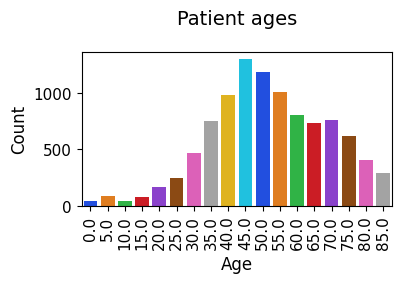

In [ ]:
data = df_data['age'].value_counts()
plt.figure(figsize=(4,2))
plt.xlabel('Age',fontsize=12)
plt.ylabel('Count',fontsize=12)
bar_plt(data.index,data.values,title='Patient ages')

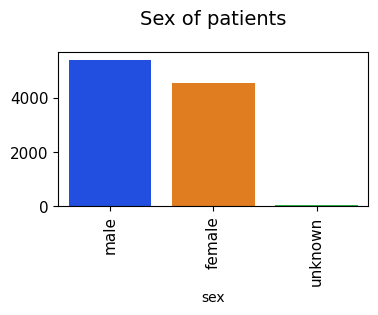

In [ ]:
data = df_data['sex'].value_counts()
plt.figure(figsize=(4,2))

bar_plt(data.index,data.values,title='Sex of patients')

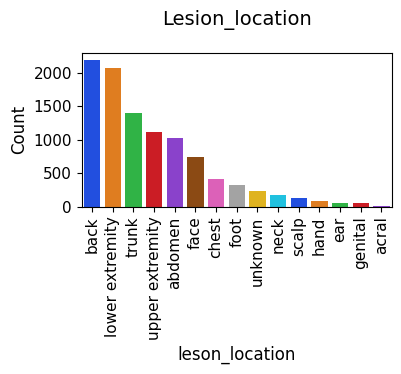

In [ ]:
data = df_data['localization'].value_counts()
plt.figure(figsize=(4,2))
plt.xlabel('leson_location',fontsize=12)
plt.ylabel('Count',fontsize=12)
bar_plt(data.index,data.values,title='Lesion_location')
plt.show()

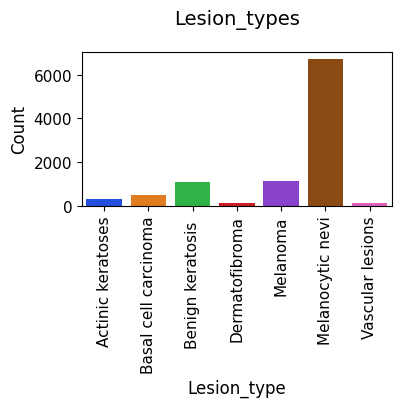

Count of Melanocytic nevi = 6705
Count of Melanoma = 1113
Count of Benign keratosis  = 1099
Count of Basal cell carcinoma = 514
Count of Actinic keratoses = 327
Count of Vascular lesions = 142
Count of Dermatofibroma = 115


In [ ]:
data = df_data['lesion_type'].value_counts()
plt.figure(figsize=(4,2))
plt.xlabel('Lesion_type',fontsize=12)
plt.ylabel('Count',fontsize=12)
bar_plt(data.index,data.values,title='Lesion_types')
plt.show()
# Print the count of each lesion type
for lesion, count in zip(data.index, data.values):
    print(f"Count of {lesion} = {count}")

##### There is a lot of imbalance in the dataset as evident from the count of various lesion types."Melanocytic nevi" has the highest count and "Dermatofibroma" has the least

##### Imbalance Ratio = 6705/115 = 58.3
##### Thus the imbalance ratio is approximately 58


In [ ]:
# Count NaN values for each row and keep the original index (image_id) intact
null_row_df = df_data.isnull().sum(axis=1).to_frame(name='NaN_Count')

# Add the original index (image_id) as a column
null_row_df['Image_ID'] = df_data.index

# Rearrange columns for clarity
null_row_df = null_row_df[['Image_ID', 'NaN_Count']]

# Sort by NaN_Count while keeping the correct association with Image_ID
null_row_df = null_row_df.sort_values(by='NaN_Count').reset_index(drop=True)

print(null_row_df)

           Image_ID  NaN_Count
0      ISIC_0029875          0
1      ISIC_0030618          0
2      ISIC_0024484          0
3      ISIC_0025134          0
4      ISIC_0029774          0
...             ...        ...
10010  ISIC_0034195          1
10011  ISIC_0033982          1
10012  ISIC_0033735          1
10013  ISIC_0033515          1
10014  ISIC_0033064          1

[10015 rows x 2 columns]


In [ ]:
print("Missing values per column:")
print(df_data.isnull().sum())

Missing values per column:
lesion_id        0
dx               0
dx_type          0
age             57
sex              0
localization     0
label            0
lesion_type      0
path             0
dtype: int64


##### Given there are 10015 rows in total and 57 rows are having null values(in the "Age" column).There is no need to drop these columns.

In [ ]:
print(df_data.info())  # Get column data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
Index: 10015 entries, ISIC_0027419 to ISIC_0032258
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lesion_id     10015 non-null  object  
 1   dx            10015 non-null  category
 2   dx_type       10015 non-null  object  
 3   age           9958 non-null   float64 
 4   sex           10015 non-null  object  
 5   localization  10015 non-null  object  
 6   label         10015 non-null  int8    
 7   lesion_type   10015 non-null  category
 8   path          10015 non-null  object  
dtypes: category(2), float64(1), int8(1), object(5)
memory usage: 835.8+ KB
None


#### Observations after Data Exploration


*  There is a lot of imbalance in the dataset(imbalance ratio = 58)
*  All the images have the same size i.e., 450x600







#### Image preprocessing

In [ ]:
# Initialize a dictionary to store the specifications for the first image
first_image_specifications = {}

# Loop through all image paths and check specifications
for idx, img_path in enumerate(df_data['path']):
    if os.path.exists(img_path):
        img = Image.open(img_path)

        # Get the specifications of the first image and store it in a dictionary
        if idx == 0:
            first_image_specifications["Format"] = img.format
            first_image_specifications["Mode"] = img.mode
            first_image_specifications["Size"] = img.size

        # Compare the specifications of the current image with the first one
        if img.format != first_image_specifications["Format"]:
            first_image_specifications["Format"] = None
        if img.mode != first_image_specifications["Mode"]:
            first_image_specifications["Mode"] = None
        if img.size != first_image_specifications["Size"]:
            first_image_specifications["Size"] = None

    else:
        first_image_specifications["Format"] = None
        first_image_specifications["Mode"] = None
        first_image_specifications["Size"] = None

# Print the final common specifications
if first_image_specifications["Format"] is not None:
    print(f"Common Format: {first_image_specifications['Format']}")
else:
    print("Formats are not the same across all images.")

if first_image_specifications["Mode"] is not None:
    print(f"Common Mode: {first_image_specifications['Mode']}")
else:
    print("Modes are not the same across all images.")

if first_image_specifications["Size"] is not None:
    print(f"Common Size: {first_image_specifications['Size']}")
else:
    print("Sizes are not the same across all images.")

Common Format: JPEG
Common Mode: RGB
Common Size: (600, 450)



*   All the images are in the same format i.e., "JPEG", "RGB" and have the same size.







---


*  The dataset was collected from different sources (e.g., Vienna Dermatology dataset & Queensland dataset).

* Some lesions have multiple images with different angles, lighting, or zoom levels.


#### Checking for the duplicate images

In [ ]:
# get number of non-unique lesion_id's
def check_duplicates(df, col):
    unique_list = df.lesion_id.unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

Duplicate lesion_ids: 2545 out of 10015




*  Lesions have their id repeated, which
means that there are multiple images for each of these lesion.
* lesion_id: This represents a unique identifier for a particular skin lesion. Multiple images can be taken of the same lesion from different angles, lighting conditions, or at different times. So, the same lesion_id may appear multiple times in the dataset.
*  image_id: This is a unique identifier for each image. Every image has a unique image_id, even if multiple images belong to the same lesion_id.




---

*  In the below code, first the data is split into training and testing sets

* Duplicates from the test set are removed so that
the model is evaluated fairly on unseen data, preventing overestimation of performance.






In [ ]:
# Load saved dataset with image paths
df_data = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_metadata.csv')

In [ ]:
df_data.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
1,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
2,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
3,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
4,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...


In [ ]:
test_set_fraction = 0.2

# randomly select the test set
df_train, df_test = model_selection.train_test_split(df_data, test_size=test_set_fraction)

# removing any duplicate images from the test set and checking
df_test = df_test.drop_duplicates(subset='lesion_id', keep="first")
num_duplicates = check_duplicates(df_test, 'lesion_id')
print(f'Duplicate lesion_ids in the test set: {num_duplicates} out of {len(df_test)}')

Duplicate lesion_ids in the test set: 0 out of 1886


In [ ]:
len(df_data)

10015

In [ ]:
len(df_train)

8012

In [ ]:
len(df_test)

1886

---


*  If a lesion_id appears in both train and test sets, we're indirectly leaking data (because the same lesion is seen during training and testing, just in different images).


*  So, removing the common lesion_id in train and test sets to prevent overlap



In [ ]:
# remove any lesions from the train set that are also in the test set
df_train = df_train[~df_train.lesion_id.isin(df_test.lesion_id)]

# finally checking if test and train dfs have no shared `lesion_ids` or `image_ids`
import collections
check_lesion_ids = df_test['lesion_id'].isin(df_train['lesion_id']).value_counts()
check_image_ids = collections.Counter(df_test.index.isin(df_train.index))
print(f'Test/train overlap? lesion_id: {int(check_lesion_ids.iloc[0]) != len(df_test)}, image_id: {check_image_ids[0] != len(df_test)}')

Test/train overlap? lesion_id: False, image_id: False


---


*   Still there can be duplicate lesion_ids in the training set, because we did not completely remove them, we just removed those that overlap with the test set




In [ ]:
num_duplicates = check_duplicates(df_train, 'lesion_id')
print(f'Duplicate lesion_ids in the training set: {num_duplicates} out of {len(df_train)}')

Duplicate lesion_ids in the training set: 1504 out of 7088


In [ ]:
# Count duplicate lesion_ids in the training set
duplicate_lesions = df_train[df_train.duplicated(subset=['lesion_id'], keep=False)]

# Group by lesion type and count duplicates
duplicate_counts_per_class = duplicate_lesions.groupby('lesion_type', observed=True).size()

# Display the counts
print("Number of duplicate lesion_ids per class:")
print(duplicate_counts_per_class)

Number of duplicate lesion_ids per class:
lesion_type
Actinic keratoses         91
Basal cell carcinoma     191
Benign keratosis         395
Dermatofibroma            42
Melanocytic nevi        1404
Melanoma                 520
Vascular lesions          50
dtype: int64


---
* To understand the impact of duplicates on each class, comparing it with the total number of images per class.

In [ ]:
# Count total images per class in training set
total_counts = df_train['lesion_type'].value_counts()

# Compare duplicates with total count
duplicate_percentage = (duplicate_counts_per_class / total_counts) * 100

# Display results
print(f"Percentage of duplicates in each class:")
print(duplicate_percentage)

Percentage of duplicates in each class:
lesion_type
Actinic keratoses       44.390244
Basal cell carcinoma    57.185629
Benign keratosis        52.387268
Dermatofibroma          60.869565
Melanocytic nevi        28.490260
Melanoma                74.179743
Vascular lesions        51.546392
dtype: float64


#### Resizing

In [ ]:
import cv2

dataset_path  = Path("/content/drive/MyDrive/HAM10000_DATASET")

def resize_and_pad(image, target_size=(224, 224)):
    old_size = image.shape[:2]  # (height, width)
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize
    img_resized = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_CUBIC)

    # Create new blank image (padded)
    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # Black padding
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return img_padded

def resize_and_save(image_path, target_size=(224, 224)):
    img = cv2.imread(str(image_path))
    img = resize_and_pad(img, target_size)
    cv2.imwrite(str(image_path), img)

# Apply resizing to all images
for img_path in dataset_path.glob("*/*.jpg"):
    resize_and_save(img_path)

print("Resizing complete.")

Resizing complete.


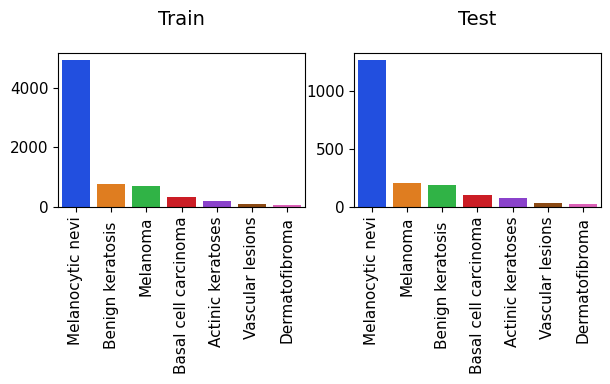

In [ ]:
# Check the balance of the train and test sets
fig, axes = plt.subplots(1, 2, figsize=(7,2))
for i, (df, title) in enumerate([(df_train, 'Train'), (df_test, 'Test')]):
    plt.subplot(1,2,i+1)
    data = df['lesion_type'].value_counts()
    bar_plt(data.keys().tolist(),data.tolist(), title=title)



*   There is a lot of imbalance between the classes in both train and test datasets
*  We need to increase the count of the minority classes in the training dataset, for this we can do data augmentation
*  Through Data Augmentation we can add extra minority class samples in the training dataset
*  This reduces the bias of the model towards the majority class





In [ ]:
df_train.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
9157,ISIC_0030593,HAM_0002685,nv,histo,30.0,male,chest,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
4003,ISIC_0027453,HAM_0000780,nv,follow_up,80.0,male,lower extremity,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
9357,ISIC_0025898,HAM_0002332,nv,consensus,0.0,male,foot,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
320,ISIC_0025838,HAM_0001362,bkl,histo,75.0,male,chest,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
3216,ISIC_0027836,HAM_0002994,nv,follow_up,50.0,female,back,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...


In [ ]:
df_test.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
2171,ISIC_0028709,HAM_0002197,mel,histo,50.0,male,back,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
2669,ISIC_0025617,HAM_0004539,bcc,histo,40.0,female,face,1,Basal cell carcinoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
6592,ISIC_0030146,HAM_0006895,nv,follow_up,65.0,female,trunk,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
5802,ISIC_0025880,HAM_0005744,nv,follow_up,50.0,male,abdomen,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
6722,ISIC_0027644,HAM_0001107,nv,histo,40.0,male,upper extremity,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...


#### Preparing training and validation datasets

In [ ]:
val_frac = 0.15
df_train_idx = df_train.copy()
df_trn, df_val = model_selection.train_test_split(df_train_idx, test_size= val_frac, random_state=142)

del df_train_idx

In [ ]:
df_trn.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
6871,ISIC_0031555,HAM_0000837,nv,histo,35.0,female,abdomen,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
6732,ISIC_0027718,HAM_0004997,nv,histo,35.0,male,back,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
7074,ISIC_0032910,HAM_0006882,nv,histo,85.0,male,foot,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
326,ISIC_0030721,HAM_0006769,bkl,histo,85.0,male,back,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
2158,ISIC_0029170,HAM_0001814,mel,histo,65.0,female,foot,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...


In [ ]:
df_val.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
8674,ISIC_0027917,HAM_0003117,nv,histo,35.0,male,upper extremity,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
4372,ISIC_0028071,HAM_0000969,nv,follow_up,40.0,female,lower extremity,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
574,ISIC_0029260,HAM_0000843,bkl,histo,70.0,male,face,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
2055,ISIC_0026094,HAM_0006696,mel,histo,20.0,male,back,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
8465,ISIC_0032141,HAM_0003723,nv,histo,60.0,female,ear,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...




*  The validation and test sets should remain imbalanced to reflect real-world distribution

*  To handle the class imbalance in the training data, data augmentation is done




In [ ]:
df_trn = df_trn[df_trn["path"].apply(os.path.exists)]
# removes rows where the image file does not exist at the given path

In [ ]:
len(df_train)

7088

In [ ]:
len(df_trn)

6023

In [ ]:
len(df_val)

1064

#### Data Augmentation for Minority Classes

In [ ]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from torchvision import transforms
from PIL import Image

# Augmentation transformations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Compute class-based augmentation multipliers
counts = df_trn['label'].value_counts()
max_count = counts.max()
aug_dict = {label: int((max_count / 3) // count) for label, count in counts.items()}

# Add augmentation multipliers to df_trn
df_trn['aug_mult'] = df_trn['label'].map(aug_dict)

# Augmented images directory
augmented_images_dir = Path("/content/drive/MyDrive/HAM10000_DATASET/augmented_images")

# Remove old augmented images before starting
if augmented_images_dir.exists():
    print("🗑️ Removing old augmented images...")
    shutil.rmtree(augmented_images_dir)

augmented_images_dir.mkdir(parents=True, exist_ok=True)

# Function to save augmented images
def augment_and_save(image_path, save_path, num_augments):
    try:
        img = Image.open(image_path).convert("RGB")  # Convert to RGB
    except Exception as e:
        print(f"⚠️ Skipping {image_path}: {e}")
        return  # Skip corrupted files

    save_path = Path(save_path)

    for i in range(num_augments):
        augmented_img = augmentations(img)
        augmented_img = transforms.ToPILImage()(augmented_img)

        full_aug_path = save_path / f"{Path(image_path).stem}_aug_{i}.jpg"
        augmented_img.save(str(full_aug_path))

    img.close()  # Free original image memory

# Apply augmentation based on computed multipliers
print("📢 Augmenting minority class images based on class multipliers...")
for row in tqdm(df_trn.itertuples(), total=len(df_trn)):
    num_augments = row.aug_mult
    if num_augments > 0:
        augment_and_save(row.path, augmented_images_dir, num_augments)

print("✅ Augmentation completed!")

🗑️ Removing old augmented images...
📢 Augmenting minority class images based on class multipliers...


100%|██████████| 6023/6023 [02:04<00:00, 48.49it/s]

✅ Augmentation completed!


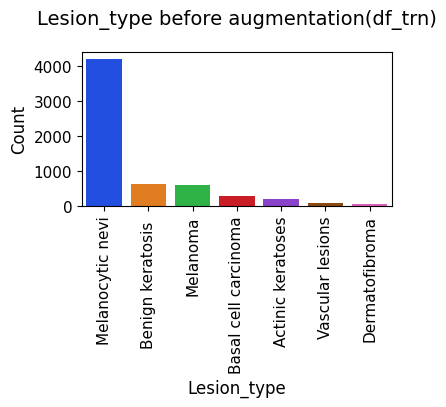

Count of Melanocytic nevi = 4197
Count of Benign keratosis  = 639
Count of Melanoma = 592
Count of Basal cell carcinoma = 273
Count of Actinic keratoses = 182
Count of Vascular lesions = 84
Count of Dermatofibroma = 56


In [ ]:
data = df_trn['lesion_type'].value_counts()
plt.figure(figsize=(4,2))
plt.xlabel('Lesion_type',fontsize=12)
plt.ylabel('Count',fontsize=12)
bar_plt(data.index,data.values,title='Lesion_type before augmentation(df_trn)')
plt.show()
# Print the count of each lesion type
for lesion, count in zip(data.index, data.values):
    print(f"Count of {lesion} = {count}")

In [ ]:
# create key relating label to lesion_type
label_list = df_trn['label'].value_counts().keys().tolist()
lesion_list = df_trn['lesion_type'].value_counts().keys().tolist()
label_to_lesion = dict(zip(label_list, lesion_list))
label_to_lesion_sorted = dict(sorted(label_to_lesion.items()))
label_to_lesion_sorted

{0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis ',
 3: 'Dermatofibroma',
 4: 'Melanoma',
 5: 'Melanocytic nevi',
 6: 'Vascular lesions'}

In [ ]:
aug_dict_sorted  = dict(sorted(aug_dict.items()))
for key, value in aug_dict_sorted.items():
    print(f"{key}: {value}")  # Prints key-value pairs in separate rows

0: 7
1: 5
2: 2
3: 24
4: 2
5: 0
6: 16


In [ ]:
augmented_images = list(Path(augmented_images_dir).glob("*.jpg"))

print("\nSample Augmented Image Paths:")
for img in augmented_images[:5]:
    print(img)


Sample Augmented Image Paths:
/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0030721_aug_0.jpg
/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0030721_aug_1.jpg
/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0029170_aug_0.jpg
/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0029170_aug_1.jpg
/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0030932_aug_0.jpg


In [ ]:
len(augmented_images)

7789

In [ ]:
len(df_trn)

6023

In [ ]:
import pandas as pd
from pathlib import Path

# Path to augmented images
augmented_images_dir = Path("/content/drive/MyDrive/HAM10000_DATASET/augmented_images")

# Get list of all augmented images
augmented_image_paths = list(augmented_images_dir.glob("*.jpg"))

# Prepare a DataFrame for augmented images
df_augmented = pd.DataFrame(columns=df_trn.columns)
df_augmented['image_id'] = [x.stem for x in augmented_image_paths]  # Extract filename without extension
df_augmented['path'] = augmented_image_paths  # Store full path

# Assign labels from original dataset
for i, row in enumerate(df_augmented.itertuples()):
    original_id = row.image_id.split('_aug')[0]  # Extract original lesion ID
    lesion_info = df_trn[df_trn['image_id'] == original_id]

    if not lesion_info.empty:
        df_augmented.loc[i, ['label', 'lesion_id', 'lesion_type']] = (
            lesion_info['label'].values[0],
            lesion_info['lesion_id'].values[0],
            lesion_info['lesion_type'].values[0]
        )

# Drop columns with all NaN values before concatenation
df_augmented = df_augmented.dropna(how='all', axis=1)

print(f'Num augmented images: {len(df_augmented)}')
display(df_augmented.head())

# Merge original and augmented dataframes
df_final = pd.concat([df_trn, df_augmented], ignore_index=True)

print(f'Final dataset size: {len(df_final)} (Original: {len(df_trn)}, Augmented: {len(df_augmented)})')

# Check the balance of the dataset
lesion_counts = df_final['label'].value_counts()

Num augmented images: 7789


,image_id,lesion_id,label,lesion_type,path
0,ISIC_0030721_aug_0,HAM_0006769,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/augmen...
1,ISIC_0030721_aug_1,HAM_0006769,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/augmen...
2,ISIC_0029170_aug_0,HAM_0001814,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/augmen...
3,ISIC_0029170_aug_1,HAM_0001814,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/augmen...
4,ISIC_0030932_aug_0,HAM_0000241,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/augmen...


Final dataset size: 13812 (Original: 6023, Augmented: 7789)


Examples of augmented images (each row contains augmented data from different lesions)


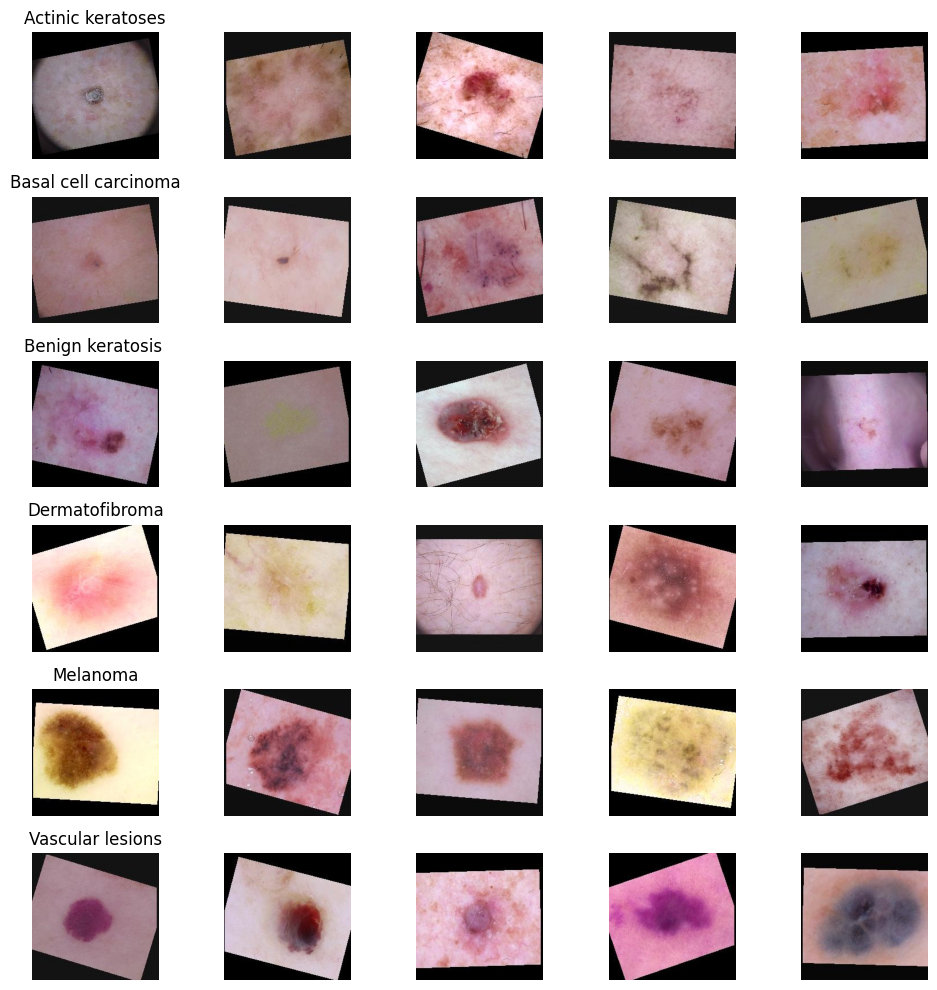

In [ ]:
print(f'Examples of augmented images (each row contains augmented data from different lesions)')
show_examples(df_augmented, "lesion_type", 5)

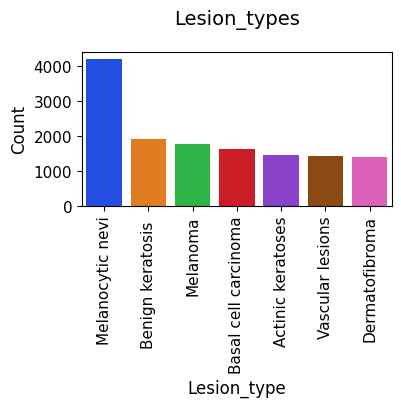

Count of Melanocytic nevi = 4197
Count of Benign keratosis  = 1917
Count of Melanoma = 1776
Count of Basal cell carcinoma = 1638
Count of Actinic keratoses = 1456
Count of Vascular lesions = 1428
Count of Dermatofibroma = 1400


In [ ]:
data = df_final['lesion_type'].value_counts()
plt.figure(figsize=(4,2))
plt.xlabel('Lesion_type',fontsize=12)
plt.ylabel('Count',fontsize=12)
bar_plt(data.index,data.values,title='Lesion_types')
plt.show()
# Print the count of each lesion type
for lesion, count in zip(data.index, data.values):
    print(f"Count of {lesion} = {count}")

#### The imbalance between the classes considerably reduced after augmentation

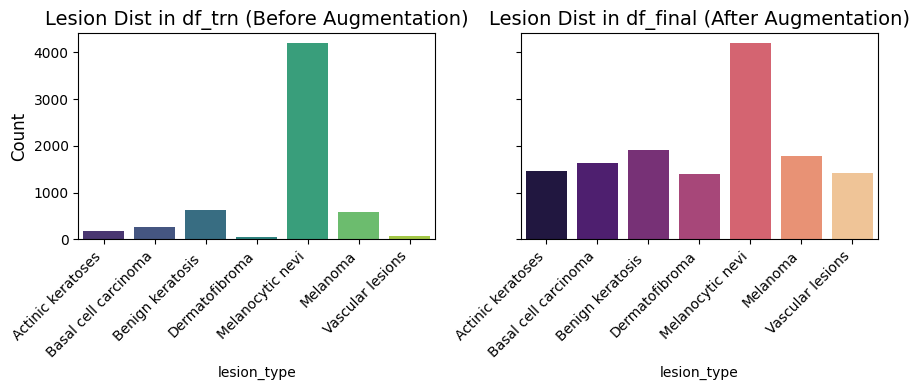

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count lesion types in both DataFrames
trn_counts = df_trn["lesion_type"].value_counts().sort_index()
final_counts = df_final["lesion_type"].value_counts().sort_index()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Plot df_trn lesion distribution
sns.barplot(x=trn_counts.index, y=trn_counts.values, ax=axes[0], hue=trn_counts.index, legend=False, palette="viridis")
axes[0].set_title("Lesion Dist in df_trn (Before Augmentation)", fontsize=14)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].set_xticks(range(len(trn_counts.index)))  # Explicitly set the tick positions
axes[0].set_xticklabels(trn_counts.index, rotation=45, ha="right")  # Ensure labels match ticks

# Plot df_final lesion distribution
sns.barplot(x=final_counts.index, y=final_counts.values, ax=axes[1], hue=final_counts.index, legend=False, palette="magma")
axes[1].set_title("Lesion Dist in df_final (After Augmentation)", fontsize=14)
axes[1].set_ylabel("")  # Remove y-axis label for better clarity
axes[1].set_xticks(range(len(final_counts.index)))  # Explicitly set the tick positions
axes[1].set_xticklabels(final_counts.index, rotation=45, ha="right")  # Ensure labels match ticks

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
len(df_train)

7088

In [ ]:
len(df_trn)

6023

In [ ]:
len(df_final)

13812

In [ ]:
df_trn.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path,aug_mult
6871,ISIC_0031555,HAM_0000837,nv,histo,35.0,female,abdomen,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0
6732,ISIC_0027718,HAM_0004997,nv,histo,35.0,male,back,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0
7074,ISIC_0032910,HAM_0006882,nv,histo,85.0,male,foot,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0
326,ISIC_0030721,HAM_0006769,bkl,histo,85.0,male,back,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,2
2158,ISIC_0029170,HAM_0001814,mel,histo,65.0,female,foot,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,2


In [ ]:
df_augmented.head()

,image_id,lesion_id,label,lesion_type,path
0,ISIC_0030721_aug_0,HAM_0006769,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/augmen...
1,ISIC_0030721_aug_1,HAM_0006769,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/augmen...
2,ISIC_0029170_aug_0,HAM_0001814,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/augmen...
3,ISIC_0029170_aug_1,HAM_0001814,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/augmen...
4,ISIC_0030932_aug_0,HAM_0000241,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/augmen...


In [ ]:
df_final.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path,aug_mult
0,ISIC_0031555,HAM_0000837,nv,histo,35.0,female,abdomen,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0.0
1,ISIC_0027718,HAM_0004997,nv,histo,35.0,male,back,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0.0
2,ISIC_0032910,HAM_0006882,nv,histo,85.0,male,foot,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0.0
3,ISIC_0030721,HAM_0006769,bkl,histo,85.0,male,back,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,2.0
4,ISIC_0029170,HAM_0001814,mel,histo,65.0,female,foot,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,2.0


In [ ]:
df_train.to_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_train.csv',index=False)

In [ ]:
df_test.to_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_test.csv',index=False)

In [ ]:
df_trn.to_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_trn.csv',index=False)

In [ ]:
df_val.to_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_val.csv',index=False)

In [ ]:
df_augmented.to_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_augmented.csv',index=False)

In [ ]:
df_final.to_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_final.csv',index=False)

---

In [ ]:
df_data = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_metadata.csv')

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_train.csv')

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_test.csv')

In [ ]:
df_trn = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_trn.csv')

In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_val.csv')

In [ ]:
df_augmented  = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_augmented.csv')

In [ ]:
df_final = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_final.csv')

---
---
Debugging steps

In [ ]:
print(f"Found {len(augmented_image_paths)} augmented images")
print(augmented_image_paths[:5])  # Print sample paths

Found 7798 augmented images
[PosixPath('/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0032719_aug_0.jpg'), PosixPath('/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0032719_aug_1.jpg'), PosixPath('/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0032709_aug_0.jpg'), PosixPath('/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0032709_aug_1.jpg'), PosixPath('/content/drive/MyDrive/HAM10000_DATASET/augmented_images/ISIC_0027437_aug_0.jpg')]


In [ ]:
for img_path in augmented_image_paths[:5]:
    img_name = img_path.stem  # Extract filename without extension
    original_id = "_".join(img_name.split("_")[:-2])  # Extract lesion ID
    print(f"Augmented image: {img_name}, Extracted lesion_id: {original_id}")

Augmented image: ISIC_0032719_aug_0, Extracted lesion_id: ISIC_0032719
Augmented image: ISIC_0032719_aug_1, Extracted lesion_id: ISIC_0032719
Augmented image: ISIC_0032709_aug_0, Extracted lesion_id: ISIC_0032709
Augmented image: ISIC_0032709_aug_1, Extracted lesion_id: ISIC_0032709
Augmented image: ISIC_0027437_aug_0, Extracted lesion_id: ISIC_0027437


In [ ]:
lesion_ids_in_trn = set(df_trn["lesion_id"])
print(f"Total unique lesion_ids in train set: {len(lesion_ids_in_trn)}")

for img_path in augmented_image_paths[:5]:
    original_id = "_".join(img_path.stem.split("_")[:-2])
    print(f"{original_id} in train set? {original_id in lesion_ids_in_trn}")

Total unique lesion_ids in train set: 4908
ISIC_0030826 in train set? False
ISIC_0030826 in train set? False
ISIC_0030826 in train set? False
ISIC_0030826 in train set? False
ISIC_0030826 in train set? False


---
---


#### Checking the datasets

In [ ]:
len(df_final)

13812

In [ ]:
len(df_val)

1064

In [ ]:
len(df_test)

1886

In [ ]:
df_final.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path,aug_mult
0,ISIC_0031555,HAM_0000837,nv,histo,35.0,female,abdomen,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0.0
1,ISIC_0027718,HAM_0004997,nv,histo,35.0,male,back,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0.0
2,ISIC_0032910,HAM_0006882,nv,histo,85.0,male,foot,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,0.0
3,ISIC_0030721,HAM_0006769,bkl,histo,85.0,male,back,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,2.0
4,ISIC_0029170,HAM_0001814,mel,histo,65.0,female,foot,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...,2.0


In [ ]:
df_val.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
8674,ISIC_0027917,HAM_0003117,nv,histo,35.0,male,upper extremity,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
4372,ISIC_0028071,HAM_0000969,nv,follow_up,40.0,female,lower extremity,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
574,ISIC_0029260,HAM_0000843,bkl,histo,70.0,male,face,2,Benign keratosis,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
2055,ISIC_0026094,HAM_0006696,mel,histo,20.0,male,back,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
8465,ISIC_0032141,HAM_0003723,nv,histo,60.0,female,ear,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...


In [ ]:
df_test.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type,path
2171,ISIC_0028709,HAM_0002197,mel,histo,50.0,male,back,4,Melanoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
2669,ISIC_0025617,HAM_0004539,bcc,histo,40.0,female,face,1,Basal cell carcinoma,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
6592,ISIC_0030146,HAM_0006895,nv,follow_up,65.0,female,trunk,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
5802,ISIC_0025880,HAM_0005744,nv,follow_up,50.0,male,abdomen,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...
6722,ISIC_0027644,HAM_0001107,nv,histo,40.0,male,upper extremity,5,Melanocytic nevi,/content/drive/MyDrive/HAM10000_DATASET/HAM100...


#### Data Preprocessing & Normalization

##### Since the data is stored in a DataFrame (with columns like path and label), we need to create a custom PyTorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class HAMDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): DataFrame containing columns 'path' and 'label'
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image: {img_path}, error: {e}")

            image = Image.new('RGB', (224,224))
        label = int(row['label'])  # Ensure label is an integer
        if self.transform:
            image = self.transform(image)
        return image, label

#### Define the Transformations

##### For many pre-trained models (e.g., ResNet), the common practice is to use the ImageNet normalization:

In [ ]:
# Define normalization parameters (ImageNet stats)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Training transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

# Validation/Test transforms (usually just resize + tensor conversion + normalization)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
# from torch.utils.data import DataLoader

# # Define transformations
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to fit ResNet
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Create dataset
# train_dataset = HAMDataset(df_final, transform=train_transform)

# # Create DataLoader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)


In [ ]:
# from torchvision import transforms
# import numpy as np

# # Compute mean and std of your dataset
# def compute_mean_std(loader):
#     mean = 0.0
#     std = 0.0
#     total_samples = 0

#     for images, _ in loader:
#         batch_samples = images.size(0)  # batch size (N, C, H, W)
#         images = images.view(batch_samples, images.size(1), -1)  # Flatten H, W
#         mean += images.mean(dim=[0, 2])
#         std += images.std(dim=[0, 2])
#         total_samples += batch_samples

#     mean /= total_samples
#     std /= total_samples
#     return mean, std

# dataset_mean, dataset_std = compute_mean_std(train_loader)
# print("Dataset Mean:", dataset_mean)
# print("Dataset Std:", dataset_std)

In [ ]:
# normalize = transforms.Normalize(mean=dataset_mean, std=dataset_std)

In [ ]:
# # Training transforms
# train_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     normalize
# ])

# # Validation/Test transforms (tensor conversion + normalization)
# val_test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     normalize
# ])

#### Create DataLoaders

In [ ]:
# Create dataset objects
train_dataset = HAMDataset(df_final, transform=train_transforms)
val_dataset = HAMDataset(df_val, transform=val_test_transforms)
test_dataset = HAMDataset(df_test, transform=val_test_transforms)

# Define DataLoader parameters
batch_size = 32

import multiprocessing

num_workers = min(2, multiprocessing.cpu_count())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Quick check: Print number of batches
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Training batches: 432
Validation batches: 34
Test batches: 59


#### Model Selection & Setup (ResNet)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the number of classes in your dataset
num_classes = df_final['label'].nunique()

# Load pre-trained ResNet
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer
in_features = model.fc.in_features  # Get input size of last layer
model.fc = nn.Linear(in_features, num_classes)  # Replace with new classification layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Loss Function & Optimizer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma  # Focusing parameter
        self.alpha = alpha  # Class weighting
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # Standard CE loss

        pt = torch.exp(-ce_loss)  # Compute pt (probability of the correct class)
        focal_loss = (1 - pt) ** self.gamma * ce_loss  # Apply the focal term

        if self.alpha is not None:  # Apply class weighting if given
            alpha_weights = self.alpha[targets]  # Get alpha for each target
            focal_loss = alpha_weights * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
class_counts = df_final["lesion_type"].value_counts()
print(class_counts)

lesion_type
Melanocytic nevi        4197
Benign keratosis        1917
Melanoma                1776
Basal cell carcinoma    1638
Actinic keratoses       1456
Vascular lesions        1428
Dermatofibroma          1400
Name: count, dtype: int64


In [ ]:
import numpy as np
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = np.array(class_weights) / max(class_weights)  # Normalize

In [ ]:
alpha = torch.tensor(class_weights, dtype=torch.float32).to("cuda")
alpha

tensor([0.3336, 0.7303, 0.7883, 0.8547, 0.9615, 0.9804, 1.0000],
       device='cuda:0')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim  # PyTorch Optimizer Library

criterion = FocalLoss(gamma=2, alpha=alpha)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#### Checkpoint Save Function

In [ ]:
import torch

def save_checkpoint(epoch, model, optimizer, val_acc, best_acc, filename="best_model.pth"):
    """Saves model checkpoint if validation accuracy improves."""
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_acc": best_acc
    }
    torch.save(state, filename)
    print(f"✅ Checkpoint saved at epoch {epoch} with val_acc: {val_acc:.4f}")

#### Training & Validation Loop

In [ ]:
import torch
import os

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10, device="cuda", checkpoint_path="best_model.pth"):
    model.to(device)
    best_acc = 0.0  # Track best accuracy
    start_epoch = 0  # Track epoch for resuming

    # 🔹 Resume training if checkpoint exists
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        best_acc = checkpoint["best_acc"]
        start_epoch = checkpoint["epoch"] + 1  # Resume from next epoch
        print(f"🔄 Resuming training from epoch {start_epoch} with best accuracy {best_acc:.4f}")

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)  # Sum loss
            _, preds = torch.max(outputs, 1)  # Get class predictions
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

        train_loss /= total_train
        train_acc = correct_train / total_train

        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)

        val_loss /= total_val
        val_acc = correct_val / total_val

        # 🔹 Save Best Model Checkpoint
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "best_acc": best_acc
            }, checkpoint_path)
            print("✅ Best Model Saved!")

        # 🔹 Step learning rate scheduler
        scheduler.step()

        # Store history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"📉 Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    return model, history

print("🚀 Training function with checkpointing is ready!")


🚀 Training function with checkpointing is ready!


#### Load Model from Checkpoint for Evaluation

In [ ]:
def load_checkpoint(model, optimizer, filename="best_model.pth"):
    """Loads model checkpoint and restores weights and optimizer state."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_acc = checkpoint["best_acc"]
    start_epoch = checkpoint["epoch"]

    print(f"✅ Loaded checkpoint from epoch {start_epoch} with best accuracy: {best_acc:.4f}")
    return model, optimizer, start_epoch, best_acc

In [ ]:
model, optimizer, start_epoch, best_acc = load_checkpoint(model, optimizer, filename="best_model.pth")

#### Training

#### ResNet50

In [ ]:
import os

checkpoint_path = "/content/drive/MyDrive/HAM10000_DATASET/best_model.pth"

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print("Checkpoint deleted. Starting fresh training.")
else:
    print("No checkpoint found. Training fresh.")

No checkpoint found. Training fresh.


In [ ]:
import torch.optim as optim
# Set Hyperparameters
num_epochs = 10
learning_rate = 0.001

trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, device="cuda")

print("\n🎉 Training Complete!")


Epoch 1/10
----------------------------------------
✅ Best Model Saved!
Train Loss: 0.5161, Train Acc: 0.5628
Val Loss: 0.4348, Val Acc: 0.6203
📉 Learning Rate: 0.001000

Epoch 2/10
----------------------------------------
✅ Best Model Saved!
Train Loss: 0.3451, Train Acc: 0.6674
Val Loss: 0.2846, Val Acc: 0.7359
📉 Learning Rate: 0.001000

Epoch 3/10
----------------------------------------
✅ Best Model Saved!
Train Loss: 0.2727, Train Acc: 0.7171
Val Loss: 0.2939, Val Acc: 0.7547
📉 Learning Rate: 0.001000

Epoch 4/10
----------------------------------------
✅ Best Model Saved!
Train Loss: 0.2234, Train Acc: 0.7547
Val Loss: 0.3315, Val Acc: 0.7801
📉 Learning Rate: 0.001000

Epoch 5/10
----------------------------------------
Train Loss: 0.1931, Train Acc: 0.7758
Val Loss: 0.2678, Val Acc: 0.7641
📉 Learning Rate: 0.001000

Epoch 6/10
----------------------------------------
Train Loss: 0.1790, Train Acc: 0.7937
Val Loss: 0.3193, Val Acc: 0.7585
📉 Learning Rate: 0.001000

Epoch 7/10
--

In [ ]:
import torch.optim as optim
# Set Hyperparameters
num_epochs = 11
learning_rate = 0.001

trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, device="cuda")

print("\n🎉 Training Complete!")

<ipython-input-107-92764e4bec8f>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


🔄 Resuming training from epoch 8 with best accuracy 0.8177

Epoch 9/11
----------------------------------------
Train Loss: 0.0589, Train Acc: 0.9141
Val Loss: 0.2199, Val Acc: 0.8026
📉 Learning Rate: 0.000100

Epoch 10/11
----------------------------------------
Train Loss: 0.0432, Train Acc: 0.9356
Val Loss: 0.2306, Val Acc: 0.8130
📉 Learning Rate: 0.000100

Epoch 11/11
----------------------------------------
Train Loss: 0.0313, Train Acc: 0.9534
Val Loss: 0.2542, Val Acc: 0.8055
📉 Learning Rate: 0.000100

🎉 Training Complete!


#### Model Evaluation on Test Set

In [ ]:
df_final = pd.read_csv('/content/drive/MyDrive/HAM10000_DATASET/processed_final.csv')

In [ ]:
class_names = df_final["lesion_type"].unique().tolist()
class_names.sort()  # Ensure consistent ordering

✅ Test Accuracy: 0.7805

📊 Classification Report:
                       precision    recall  f1-score   support

    Melanocytic nevi       0.57      0.22      0.32        73
   Benign keratosis        0.71      0.67      0.69        97
            Melanoma       0.49      0.50      0.50       189
Basal cell carcinoma       1.00      0.19      0.32        26
   Actinic keratoses       0.55      0.45      0.50       205
    Vascular lesions       0.86      0.93      0.89      1267
      Dermatofibroma       0.91      0.69      0.78        29

            accuracy                           0.78      1886
           macro avg       0.73      0.52      0.57      1886
        weighted avg       0.77      0.78      0.77      1886



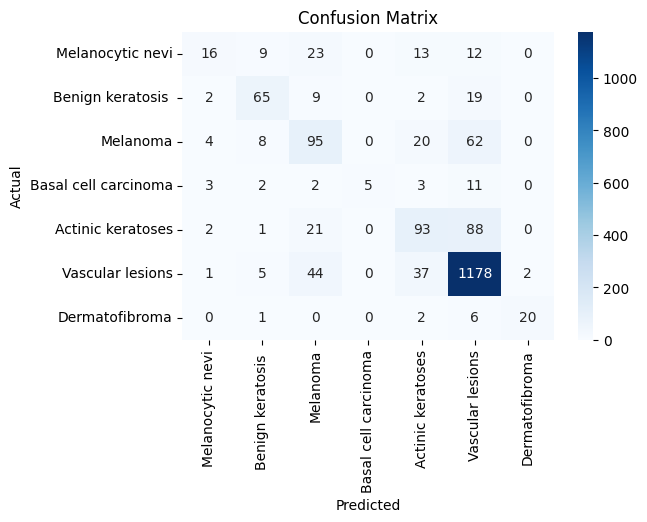

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Step 1: Load Best Model
model.eval()  # Set model to evaluation mode

all_preds = []
all_labels = []

# Step 2: Run Inference on Test Set
with torch.no_grad():  # No gradient computation needed
    for images, labels in test_loader:
        images, labels = images.to("cuda"), labels.to("cuda")

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 3: Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Print classification report
print("📊 Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Step 4: Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### Visualizing Model Predictions

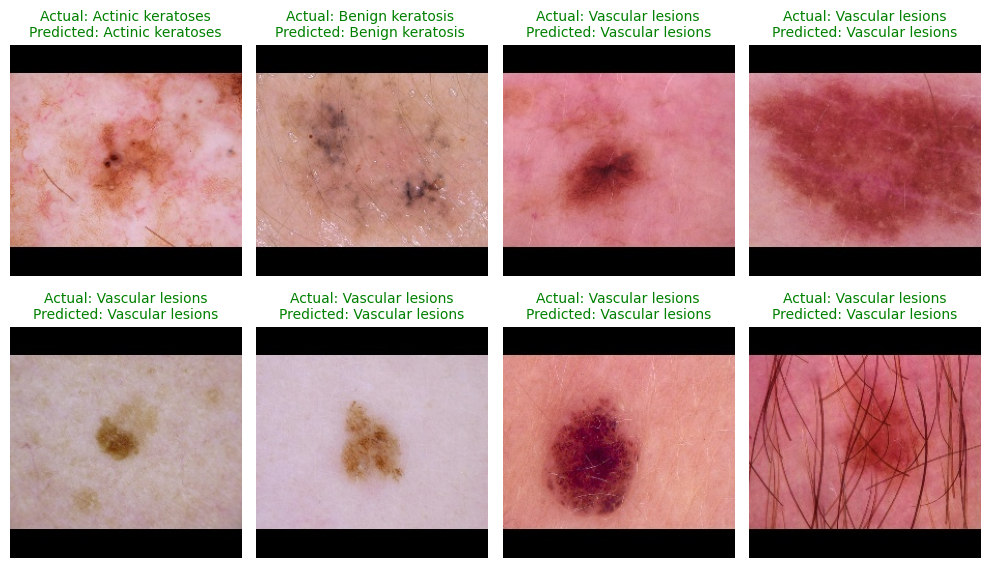

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get Some Test Samples
num_samples = 8  # Number of images to display
test_images, test_labels = next(iter(test_loader))  # Get a batch
test_images, test_labels = test_images.to("cuda"), test_labels.to("cuda")

# Step 2: Run Model Prediction
model.eval()
with torch.no_grad():
    outputs = model(test_images)
    _, preds = torch.max(outputs, 1)  # Get predicted labels

# Step 3: Display Images with Predictions
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()

for i in range(num_samples):
    img = test_images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to numpy
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)  # Ensure valid range

    label = class_names[test_labels[i].item()]
    pred = class_names[preds[i].item()]

    axes[i].imshow(img)
    axes[i].set_title(f"Actual: {label}\nPredicted: {pred}", fontsize=10,
                      color="green" if label == pred else "red")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location="cuda")  # Load on GPU if available

# Initialize the same model architecture
model = models.resnet50(num_classes=len(class_names))
model.load_state_dict(checkpoint['model_state_dict'])
model.to("cuda")
model.eval()  # Set model to evaluation mode

# Restore optimizer and scheduler (if continuing training)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

print(f"Model restored from {checkpoint_path}, trained till epoch {checkpoint['epoch']}")

---
---

#### **REFRENCES**


*  Robust Asymmetric Loss for Multi-Label Long-Tailed Learning
https://arxiv.org/abs/2308.05542

*    Focal Loss for Dense Object Detection
https://arxiv.org/abs/1708.02002v2
* Asymmetric Loss For Multi-Label Classification
https://arxiv.org/abs/2009.14119
*   Simple and Robust Loss Design for Multi-Label Learning with Missing Labels
https://arxiv.org/abs/2112.07368

